In [33]:
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
import laspy

import random
import math

In [34]:
# GET GROUND HEIGHT

las = laspy.read('data/banska4.las')
ground_data = las[las.classification == 2] 
points_data = np.stack([ground_data.Z], axis = 0).transpose((1,0))

points_sum = 0
data_min = min(points_data)

for i in range(len(points_data)):
    points_sum += points_data[i][0] - data_min[0]

avg_ground_height = math.floor(points_sum / len(points_data) + data_min[0])

In [35]:
# GET TREE EPS

tree_data = las[las.classification == 5]
points_data = np.stack([tree_data.Z], axis = 0).transpose((1,0))

points_data = sorted(points_data, key=lambda x: x[0], reverse=True)
points_data = points_data[:100]

points_sum = 0
data_min = min(points_data)

for i in range(len(points_data)):
    points_sum += points_data[i][0] - data_min[0]

avg_tree_height = math.floor(points_sum / len(points_data) + data_min[0])
tree_eps = (avg_tree_height - avg_ground_height) // 4

In [36]:
# FIRST CLUSTERING

points_data = np.stack([tree_data.X,tree_data.Y,tree_data.Z], axis = 0).transpose((1,0))
geom = o3d.geometry.PointCloud()
geom.points = o3d.utility.Vector3dVector(points_data)
geom = geom.remove_radius_outlier(3,1000)[0]

labels = np.array(geom.cluster_dbscan(tree_eps, 6))
random_colors = []
for label in labels:
    if label == -1:
        random_colors.append([0,0,0])
    else:    
        random_colors.append([random.random()*0.8 +0.2,random.random()*0.8 +0.2,random.random()*0.8 +0.2])
colors = [random_colors[x] for x in labels]
geom.colors = o3d.utility.Vector3dVector(colors)
o3d.visualization.draw_geometries([geom])

In [37]:
# GET SIZE OF EACH CLUSTER


cluster_sizes = []
for i in set(labels):
   cluster_sizes.append((i, labels.tolist().count(i)))
#plt.figure()
#plt.plot([x for x in range(max(labels)+2)],[x[1] for x in cluster_sizes])
#plt.show()

In [38]:
# SEPARATE WELL AND SHITTY CLUSTERED POINTS WITH LABELS

clusters_sorted = sorted(cluster_sizes,key=lambda x: x[1],reverse=True)
clusters_sizes_sorted = [x[1] for x in clusters_sorted]
avg_cluster_size = sum(clusters_sizes_sorted) / len(clusters_sizes_sorted)

well_clustered_points = []
well_clustered_labels = []
bad_clustered_points = []
bad_clustered_labels = []
all_points = np.asarray(geom.points)


for i in range(len(all_points)):
    for cluster in clusters_sorted:
        """
            For each point, find cluster of point. 
            If the cluster is smaller than 3*avereage_cluster_size, than put point to well separated part of dataset. 
            If the cluster is bigger, put the point to bad separated part
        """
        if labels[i] == cluster[0]:
            if cluster[1] > avg_cluster_size * 3:
                bad_clustered_points.append(all_points[i])
                bad_clustered_labels.append(labels[i])
            else:
                well_clustered_points.append(all_points[i])
                well_clustered_labels.append(labels[i])         

pointcloud_final = o3d.geometry.PointCloud()
pointcloud_final.points = o3d.utility.Vector3dVector(bad_clustered_points)
o3d.visualization.draw_geometries([pointcloud_final])

In [39]:
# 2ND CLUSTERING + APPENDING TO WELL CLUSTERED POINTS

big_cluster = o3d.geometry.PointCloud()

"""For each bit cluster"""
for label in set(bad_clustered_labels):
    points_of_one_bad_cluster = []
    """Create list of all points of one big cluster"""
    for i in range(len(bad_clustered_points)):
        if bad_clustered_labels[i] == label:
            points_of_one_bad_cluster.append(bad_clustered_points[i])

    big_cluster.points = o3d.utility.Vector3dVector(points_of_one_bad_cluster)
    """"DBSCAN one big cluster"""
    labels_round_2 = np.array(big_cluster.cluster_dbscan(tree_eps/3, 8))

    label_baseline = max(well_clustered_labels) + 1
    print(well_clustered_labels)
    print(max(well_clustered_labels))
    print("BASELINE:", label_baseline)
    print(len(set(labels_round_2)))

    """Append DBSCANNED big cluster to well separated points/labels"""
    for j in range(len(labels_round_2)):
        if labels_round_2[j] != -1:
            well_clustered_points.append(points_of_one_bad_cluster[j])
            well_clustered_labels.append(labels_round_2[j] + label_baseline)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, -1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 3, 3, 3, 2, 2, 2, 2, 2, 3, 3, 3, 2, 2, 2, 3, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 8, 8, 8, 7, 7, 7, 8, 8, 7, 7, 7, 7, 8, 8, 8, 8, 7, 8, 8, 8, 7, 8, 8, 8, 8, 7, 8, 8, 8, 9, 9, 8, 8, 8, 9, 9, 8, 8, 8, 8, 8, 9, 9, 9, 8, 8, 8, 8, 9, 9, 8, 9, 9, 9, 9, 8, 9, 9, 9, 9, 8, 9, 9, 9, 9, 9, 9, 9, 9, 8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,

In [45]:
# PAINT AND VISUALIZE FINAL DATA 

random_colors_final = []
for l in well_clustered_labels:
    if label == -1:
        random_colors_final.append([0,0,0])
    else:    
        random_colors_final.append([random.random()*0.8 +0.2,random.random()*0.8 +0.2,random.random()*0.8 +0.2])
colors_final = [random_colors_final[x] for x in well_clustered_labels]

pointcloud_final.points = o3d.utility.Vector3dVector(well_clustered_points)
pointcloud_final.colors = o3d.utility.Vector3dVector(colors_final)
o3d.visualization.draw_geometries([pointcloud_final])

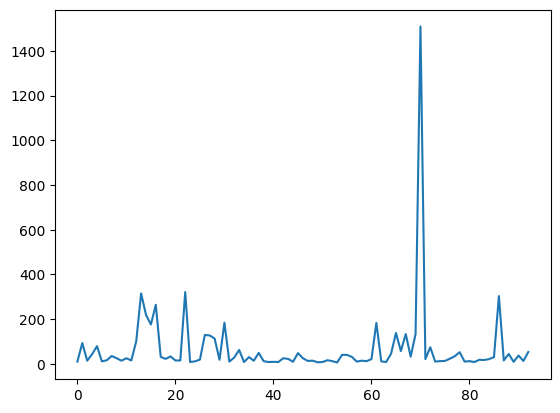

In [50]:

cluster_sizes = []
for i in set(well_clustered_labels):
   cluster_sizes.append((i, well_clustered_labels.count(i)))

plt.figure()
plt.plot([x for x in range(max(well_clustered_labels) -1)],[x[1] for x in cluster_sizes])
plt.show()